In [2]:
import pandas as pd
import numpy as np
from gensim.models import LdaModel, CoherenceModel
from gensim import corpora
import seaborn as sns
import matplotlib.pylab as plt
from scipy.stats import pearsonr
from matplotlib.colors import ListedColormap
from scipy import stats as st
import matplotlib.colors as mcolors

In [3]:
file = pd.read_table('/home/janneae/cns/steps/featurefiles/discretized_10_0.7_5.features', dtype=str)
survivaldata = pd.read_table('/home/janneae/TCGA/DerivedData/TCGA_survival_data_clean.txt')
mutations = pd.read_table('../data/all_muts_pass_and_polyphen.txt', sep=' ')
gene_exp = pd.read_table('../data/all_tcga_gene_exp.txt', sep='\t')
maf = pd.read_table('../data/all_tcga_maf.txt', sep=' ')
cin_loc = pd.read_table('../data/cin_locations.txt')
sanchez_vega = pd.read_table('../data/sanchez_vega_pws_1026.csv', sep=';')

/scratch/64400898/ipykernel_13354/69555841.py:3: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  mutations = pd.read_table('../data/all_muts_pass_and_polyphen.txt', sep=' ')


In [4]:
lda = LdaModel.load(f'/home/janneae/cns/steps/gensim/lda/lda_t5_f10_b5.model')
df = file.drop(['Sample', 'Chr'], axis = 1)
listedDf = df.values.tolist()
dirichlet_dict = corpora.Dictionary(listedDf)
bow_corpus = [dirichlet_dict.doc2bow(text) for text in listedDf]

## Feature distributions

In [5]:
topics = lda.show_topics(num_words=50, formatted=False)

out = []
for i, topic in topics:
    topic = sorted(topic)
    for word, weight in topic:
        out.append([word, i + 1, weight])
        
df = pd.DataFrame(out, columns=['word', 'topic_id', 'weight'])
prefixes = ['CN', 'SegSize', 'Dist2Cent', 'SegVal', 'LOH', 'SizeDipSeg', 'CpCN', 'Dist2CNV', 'GCcSeg']

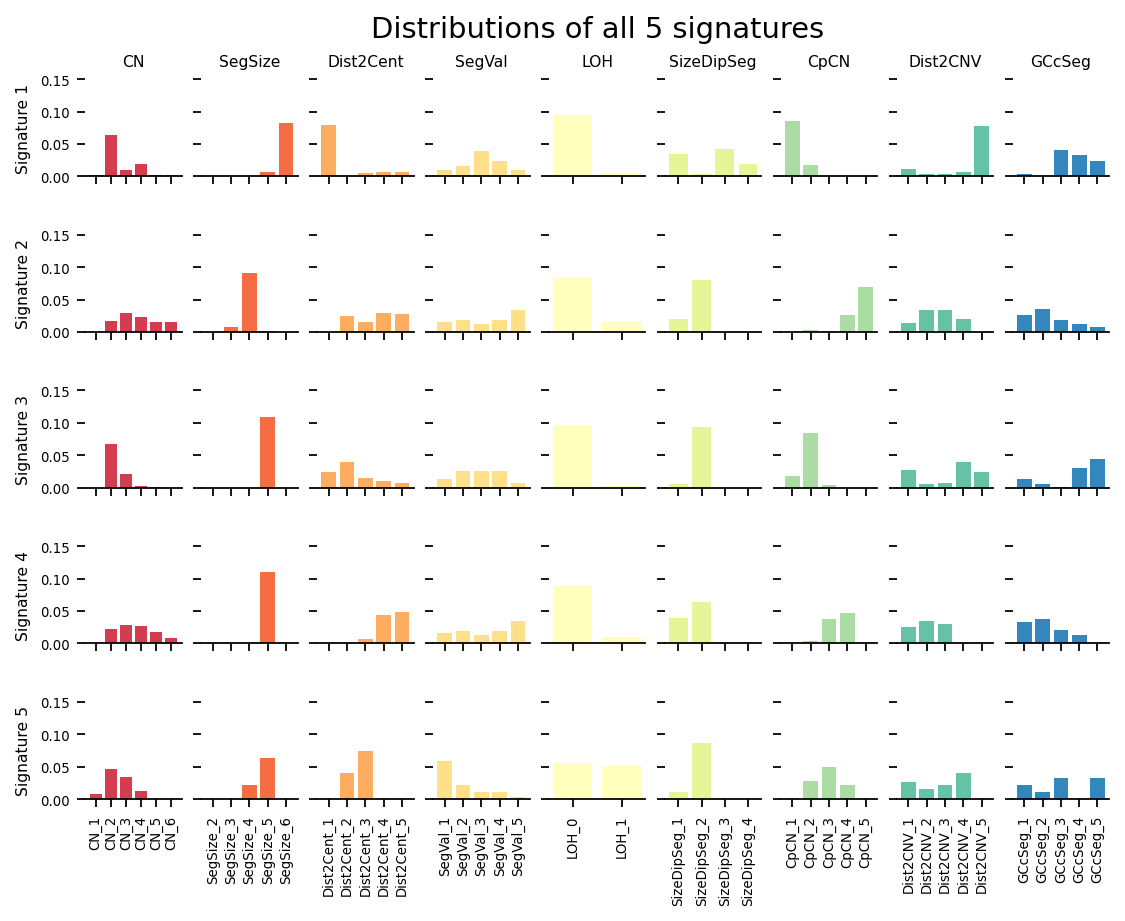

In [6]:
palette = sns.color_palette(palette="Spectral", n_colors=9)

fig, axes = plt.subplots(5, 9, figsize=(8,5), sharey=True, dpi=160)

for i, ax in enumerate(axes):
    data = df[df['topic_id']==i+1]
    ax[0].set_ylabel(f'Signature {i+1}', fontsize=7)
    for j in range(0, 9):
        ax[j].bar(x='word', height="weight", 
                  data=data[data['word'].str.startswith(prefixes[j])], 
                  width=0.8, color=palette[j])
        if i < 4:
            ax[j].xaxis.set_ticklabels([])
        if i == 0:
            ax[j].set_title(prefixes[j], fontsize=7)
    
for ax in axes.flatten():
    ax.set_ylim(0, 0.15)
    ax.tick_params(axis='x', rotation=90, labelsize=6)
    ax.tick_params(axis='y', labelsize=6)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['top'].set_visible(False)

plt.subplots_adjust(left=0.1, bottom=0, right=0.9, top=0.9, wspace=0.2, hspace=0.6)
fig.suptitle('Distributions of all 5 signatures', fontsize=13)
fig.savefig('../figures/all_signatures.pdf')
plt.show()

## Heatmap with signature weights

In [7]:
def create_heatmap(model, df):
    topics = model.get_document_topics(bow = bow_corpus, minimum_probability = 0)
    
    new_df = pd.DataFrame(df['Sample'])
    new_df['Chr'] = df['Chr']
    new_df['Chr'] = pd.to_numeric(new_df['Chr'])
    
    columns = [[],[],[],[],[]]
    for topic in topics:
        for w in topic:
            columns[w[0]].append(w[1])
    
    new_df['1'] = columns[0]
    new_df['2'] = columns[1]
    new_df['3'] = columns[2]
    new_df['4'] = columns[3]
    new_df['5'] = columns[4]
    new_df = new_df.sort_values(by='Chr')
    return new_df

In [8]:
weights_df = create_heatmap(lda, file)
weights_df = weights_df[weights_df['Chr'] != 23]
heatmap_df = weights_df.drop('Sample', axis = 1).set_index('Chr').transpose()

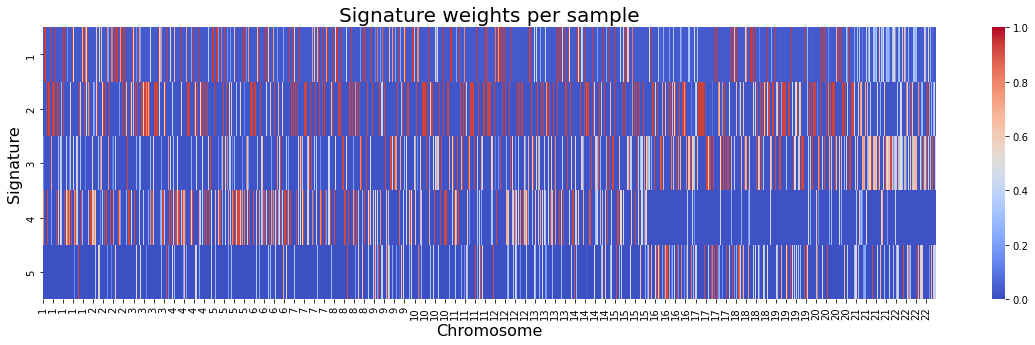

In [9]:
plt.figure(figsize=(20,5))
ax = sns.heatmap(heatmap_df, cmap='coolwarm', vmin=0, vmax=1)
ax.tick_params(axis="both", which="major", labelsize=10)
plt.xlabel('Chromosome', fontsize=16)
plt.ylabel('Signature', fontsize=16)
plt.title("Signature weights per sample", fontsize=20)
plt.savefig('../figures/heatmap.pdf')
plt.show()

## Correlating signatures with CIN variables

In [15]:
cin = pd.read_table("../data/all_tcga_cin_measures.txt", sep=" ").set_index('sample_id').reindex(index=weights_df['Sample']).reset_index()

In [25]:
combined_cin = weights_df.reset_index(drop=True)
combined_cin['Telomeric.AI'] = cin['Telomeric.AI']
combined_cin['lst'] = cin['lst']
combined_cin['hrd'] = cin['hrd']
combined_cin['wGII'] = cin['wGII']
combined_cin['ploidy'] = cin['Ploidy']
combined_cin['hrd_score'] = cin['lst'] + cin['Telomeric.AI'] + cin['hrd']
combined_cin['wFLOH'] = cin['wFLOH']
combined_cin = combined_cin.dropna().reset_index(drop=True)

In [27]:
combined_df = weights_df.reset_index()
combined_df['Age_at_diagnosis'] = survivaldata['age_at_initial_pathologic_diagnosis']
combined_df['Gender'] = survivaldata['gender']
combined_df['Gender'] = pd.factorize(combined_df['Gender'])[0]
combined_df = combined_df.dropna()
combined_df

,index,Sample,Chr,1,2,3,4,5,Age_at_diagnosis,Gender
0,0,TCGA-02-0001,1,0.608773,0.021746,0.016279,0.012962,0.340240,58.0,0
1,31438,TCGA-76-6280,1,0.035877,0.530901,0.016230,0.406124,0.010868,44.0,1
2,134112,TCGA-J8-A3YD,1,0.938911,0.021100,0.016200,0.012934,0.010854,23.0,1
3,134090,TCGA-J8-A3O1,1,0.031361,0.580667,0.016137,0.360972,0.010862,23.0,1
4,31460,TCGA-76-6282,1,0.034990,0.021826,0.292266,0.640052,0.010866,30.0,0
...,...,...,...,...,...,...,...,...,...,...
11155,22903,TCGA-49-4514,2,0.031473,0.021749,0.016094,0.919827,0.010857,75.0,0
11156,4093,TCGA-06-A7TL,2,0.035049,0.925049,0.016072,0.012975,0.010855,79.0,1
11157,118361,TCGA-FD-A5C1,2,0.033582,0.021963,0.016254,0.732720,0.195480,51.0,1
11158,45893,TCGA-AB-2885,2,0.031823,0.021958,0.016260,0.919082,0.010877,50.0,1


In [22]:
def correlate(cin, survival, val):
    gender = []
    age = []
    tel = []
    lst = []
    hrd = []
    hrd_score = []
    ploidy = []
    wGII = []
    wFLOH = []
    
    for i in range(1, 6):
        gender.append(pearsonr(survival[f'{i}'], survival['Gender'])[val])
        age.append(pearsonr(survival[f'{i}'], survival['Age_at_diagnosis'])[val])
        tel.append(pearsonr(cin[f'{i}'], cin['Telomeric.AI'])[val])
        lst.append(pearsonr(cin[f'{i}'], cin['lst'])[val])
        hrd.append(pearsonr(cin[f'{i}'], cin['hrd'])[val])
        hrd_score.append(pearsonr(cin[f'{i}'], cin['hrd_score'])[val])
        ploidy.append(pearsonr(cin[f'{i}'], cin['ploidy'])[val])
        wGII.append(pearsonr(cin[f'{i}'], cin['wGII'])[val])
        wFLOH.append(pearsonr(cin[f'{i}'], cin['wFLOH'])[val])
    
    corr_df = pd.DataFrame([1, 2, 3, 4, 5], columns=['Signature'])
    corr_df['Gender'] = gender
    corr_df['Age_at_diagnosis'] = age
    corr_df['Telomeric.AI'] = tel
    corr_df['LST'] = lst
    corr_df['HRD'] = hrd
    corr_df['HRD_score'] = hrd_score
    corr_df['Ploidy'] = ploidy
    corr_df['wGII'] = wGII
    corr_df['wFLOH'] = wFLOH
    
    corr_df = corr_df.set_index('Signature')
    # corr_df = corr_df.transpose()
    
    return corr_df

In [28]:
corr_df = correlate(combined_cin, combined_df, 0)
pval_df = correlate(combined_cin, combined_df, 1)

In [46]:
cin70_corr = []
cin70_pval = []

for signature in range(1, 6):
    cin70_corr.append(st.pearsonr(exp[f'Sig{signature}'], cin70_expT['mean'])[0])
    cin70_pval.append(st.pearsonr(exp[f'Sig{signature}'], cin70_expT['mean'])[1])

In [47]:
corr_df['CIN70'] = cin70_corr
pval_df['CIN70'] = cin70_pval
corr_df = corr_df.transpose()
pval_df = pval_df.transpose()

In [51]:
alpha = 0.001

for i in range(0, 9):
    for j in range(0, 4):
        if pval_df.iloc[i, j] > alpha:
            corr_df.iloc[i, j] = 0
corr_df

Signature,1,2,3,4,5
Gender,0.000000,0.000000,0.000000,0.000000,0.014009
Age_at_diagnosis,0.000000,0.000000,0.000000,0.000000,0.013453
Telomeric.AI,0.000000,0.412312,-0.263436,0.008163,0.073553
LST,-0.284631,0.000000,0.000000,-0.002260,0.065381
HRD,-0.268692,0.300003,-0.187031,-0.007239,0.103920
HRD_score,0.000000,0.395976,-0.247929,0.000000,0.085221
Ploidy,-0.085779,0.000000,0.000000,0.000000,-0.041052
wGII,0.000000,0.315198,0.000000,0.072054,0.083047
wFLOH,0.000000,0.000000,0.000000,0.000000,0.150395
CIN70,-0.322443,0.314668,-0.159348,0.066151,-0.112918


In [52]:
pval_df

Signature,Signature_1,Signature_2,Signature_3,Signature_4,Signature_5
TSPAN6,1.267501e-02,1.362576e-04,2.088073e-01,2.359999e-06,1.759336e-03
TNMD,5.967782e-01,1.834407e-05,4.924565e-06,5.157976e-01,8.267631e-01
DPM1,8.950103e-01,3.656948e-71,2.243783e-40,6.185101e-16,8.625055e-05
SCYL3,1.227968e-17,8.123128e-06,1.807712e-03,2.180797e-18,4.170872e-10
C1orf112,8.658222e-14,6.076380e-129,5.939330e-108,8.848768e-44,3.684303e-20
...,...,...,...,...,...
TEX13D,3.165708e-01,1.043301e-03,9.736387e-04,1.127800e-01,1.099528e-01
ADORA3,1.520074e-03,1.286341e-11,6.083078e-12,5.229333e-01,6.590476e-01
DUXB,7.305341e-01,3.575686e-04,2.359565e-02,1.304584e-01,1.492027e-01
TEX13C,1.579705e-01,1.500337e-07,2.327029e-04,1.727722e-05,6.165859e-01


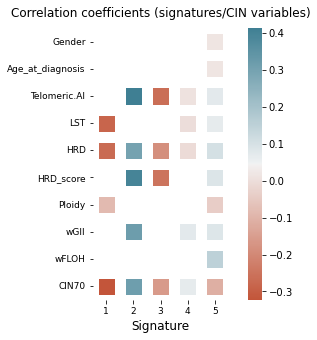

In [53]:
palette = sns.diverging_palette(20, 220, as_cmap=True)

f, ax = plt.subplots(figsize=(7, 5))
ax = sns.heatmap(
    corr_df[corr_df!=0],
    # vmin=-0.5, vmax=0.5, 
    cmap=palette,
    square=True,
    linewidths=11)
    
plt.xlabel("Signature", fontsize=12)
ax.tick_params(axis="both", which="major", labelsize=9)
plt.title("Correlation coefficients (signatures/CIN variables)", size=12, y=1.02)
plt.savefig('../figures/correlation_matrix.pdf')

## Difference in mean signature weights

In [14]:
high_impact = mutations[mutations['PolyPhen_num']>0.99]
gene_list = list(high_impact.drop_duplicates(subset = ["Hugo_Symbol"])['Hugo_Symbol'])

In [15]:
mut = weights_df.reset_index(drop=True)
mut = mut.rename(columns = {'Sample': 'sampleID'})
# mut= mut.drop_duplicates(subset = ["sampleID"])
mut = pd.merge(left = mut, right = maf[['sampleID', 'mutatated_genes']], on='sampleID')

gene_list = ['TP53', 'PTEN', 'NF1', 'MYC', 'CDK12', 'CCNE1', 'BRCA2', 'BRCA1']
# gene_list = list(cin_loc['Gene'])

for gene in gene_list:
    mut[gene] = np.where(mut['mutatated_genes'].str.contains(gene), True, False)

mut

,sampleID,Chr,1,2,3,4,5,mutatated_genes,TP53,PTEN,NF1,MYC,CDK12,CCNE1,BRCA2,BRCA1
0,TCGA-C4-A0F7,1,0.037110,0.919098,0.017613,0.014241,0.011939,"HNF1A, TP53",True,False,True,False,False,False,False,False
1,TCGA-C4-A0F7,2,0.036457,0.919694,0.017634,0.014270,0.011945,"HNF1A, TP53",True,False,True,False,False,False,False,False
2,TCGA-C4-A0F7,3,0.036371,0.919767,0.017649,0.014269,0.011944,"HNF1A, TP53",True,False,True,False,False,False,False,False
3,TCGA-C4-A0F7,4,0.037275,0.752168,0.017627,0.014254,0.178676,"HNF1A, TP53",True,False,True,False,False,False,False,False
4,TCGA-C4-A0F7,5,0.035478,0.920718,0.017594,0.014261,0.011948,"HNF1A, TP53",True,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99875,TCGA-XF-A8HC,18,0.171206,0.784897,0.017681,0.014263,0.011952,ERBB2,False,False,False,False,False,False,False,False
99876,TCGA-XF-A8HC,19,0.713974,0.024259,0.017679,0.014244,0.229844,ERBB2,False,False,False,False,False,False,False,False
99877,TCGA-XF-A8HC,20,0.719897,0.023384,0.230515,0.014254,0.011950,ERBB2,False,False,False,False,False,False,False,False
99878,TCGA-XF-A8HC,21,0.627291,0.024031,0.322422,0.014308,0.011947,ERBB2,False,False,False,False,False,False,False,False


In [16]:
sig = [1, 2, 3, 4, 5]
gene_df = pd.DataFrame(sig, columns=['Signature'])

for gene in gene_list:
    p_values = []
    for i in range(1, len(sig)+1):
        a = mut[mut[gene] == True][str(i)]
        b = mut[mut[gene] == False][str(i)]
        if len(a) == 0 or len(b) == 0: break
        else: 
            p = st.mannwhitneyu(x=a, y=b, alternative='two-sided')[1]
            p_values.append(p)
    if len(p_values) == 5: gene_df[gene] = p_values
    else: continue
gene_df = gene_df.set_index('Signature').transpose()
gene_df

Signature,1,2,3,4,5
TP53,0.173708,0.000000e+00,0.000000e+00,0.000423,1.052232e-86
PTEN,0.002908,1.612273e-15,6.029474e-11,0.000755,5.104076e-02
NF1,0.000068,4.988410e-01,7.364591e-06,0.000952,2.162009e-01
MYC,0.270429,2.415173e-01,1.228743e-02,0.048901,5.949807e-01
CDK12,0.393557,1.763932e-15,1.013576e-06,0.000035,6.725717e-02
BRCA2,0.107212,6.997101e-06,7.240293e-07,0.145783,2.293856e-01
BRCA1,0.255439,2.274526e-18,6.553381e-08,0.510760,8.065847e-02


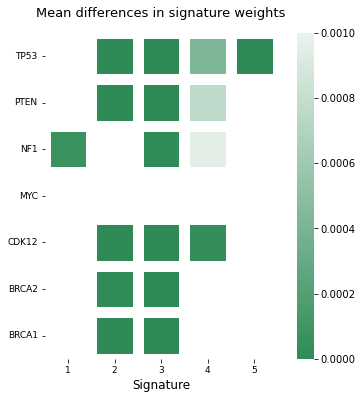

In [17]:
alpha = 0.001
palette = sns.light_palette("seagreen", reverse=True, as_cmap=True)
# palette = sns.diverging_palette(10, 220, as_cmap=True)

f, ax = plt.subplots(figsize=(7, 6))
ax = sns.heatmap(
    gene_df[gene_df<alpha],
    vmin=0, vmax=alpha, 
    cmap=palette,
    square=True,
    linewidths=11)
    
plt.xlabel("Signature", fontsize=12)
plt.yticks(rotation=0)
ax.tick_params(axis="both", which="major", labelsize=9)
plt.title("Mean differences in signature weights", fontsize=13, y=1.03)
plt.savefig('../figures/correlation_matrix_cin70.pdf')

## Gene Expression

In [54]:
gene_expT = gene_exp.transpose()
gene_expT['Sample'] = gene_expT.index
gene_expT

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,OR8K3,CCDC163,PAGR1,RPS4Y2,TMEM265,TEX13D,ADORA3,DUXB,TEX13C,Sample
TCGA-19-1787,5.5438,2.8974,5.2327,1.23330,2.90900,2.7826,2.64180,5.58980,3.62890,3.25410,...,-9.9658,2.77000,5.46500,-9.9658,3.0446,-9.9658,4.98420,-9.9658,-6.50640,TCGA-19-1787
TCGA-S9-A7J2,5.3709,-1.7809,4.6972,2.33660,1.51150,1.5514,1.14470,3.40340,5.46730,4.46340,...,-9.9658,2.66700,5.40130,-9.9658,3.1908,-9.9658,2.80760,-9.9658,-4.29340,TCGA-S9-A7J2
TCGA-G3-A3CH,5.4422,-3.6370,4.3111,1.93840,-0.19515,1.6659,8.60775,4.64695,4.74575,2.05375,...,-9.9658,-0.32265,3.93430,-9.9658,0.9153,-9.9658,1.01890,-9.9658,-9.96580,TCGA-G3-A3CH
TCGA-EK-A2RE,4.7077,-9.9658,5.8585,2.08100,2.86220,-0.2159,3.10790,4.89340,4.03130,3.07910,...,-9.9658,-0.23280,4.73400,-9.9658,6.1416,-9.9658,-1.21420,-9.9658,-9.96580,TCGA-EK-A2RE
TCGA-44-6778,3.9800,-6.7119,5.3509,2.68705,1.63215,5.5077,4.90205,5.10775,4.21175,3.97765,...,-9.9658,1.26620,4.28085,-7.0004,3.4035,-9.9658,1.88605,-9.9658,-1.40405,TCGA-44-6778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-95-7947,5.8370,-1.5522,6.3884,3.82080,3.46870,3.3264,5.79500,6.34180,5.77450,4.81610,...,-9.9658,1.22710,5.69460,-9.9658,6.0492,-9.9658,1.29920,-9.9658,-9.96580,TCGA-95-7947
TCGA-VQ-AA6F,3.2988,-9.9658,5.1526,2.59480,2.22060,1.3846,4.04620,5.09640,6.39900,6.31540,...,-9.9658,0.82460,4.27060,-5.5735,5.6473,-9.9658,-1.99420,-9.9658,-9.96580,TCGA-VQ-AA6F
TCGA-BR-8588,3.2959,-3.1714,5.1244,2.40900,2.97470,2.6278,4.69600,5.04840,3.35490,3.33500,...,-9.9658,0.08540,4.28330,-9.9658,2.9128,-9.9658,1.51150,-9.9658,-9.96580,TCGA-BR-8588
TCGA-24-2254,6.5220,-1.6850,5.6372,2.52880,2.98390,3.1507,6.21080,5.74070,4.91320,4.99150,...,-9.9658,0.43400,5.31290,-9.9658,3.3883,-9.9658,3.42100,-9.9658,-9.96580,TCGA-24-2254


In [55]:
exp = weights_df.reset_index(drop=True).drop(['Chr'], axis = 1).drop_duplicates(subset = ["Sample"])
exp.columns = ['Sample', 'Sig1', 'Sig2', 'Sig3', 'Sig4', 'Sig5']
exp = pd.merge(left = exp, right = gene_expT, on = 'Sample')

In [56]:
exp.index = exp['Sample']
exp = exp.drop(['Sample'], axis = 1)
exp

,Sig1,Sig2,Sig3,Sig4,Sig5,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,...,PRAMEF26,OR8K3,CCDC163,PAGR1,RPS4Y2,TMEM265,TEX13D,ADORA3,DUXB,TEX13C
Sample,,,,,,,,,,,,,,,,,,,,,
TCGA-J8-A3YD,0.938911,0.021100,0.016200,0.012934,0.010854,5.1240,-4.2934,5.5659,2.6556,1.1706,...,-9.9658,-9.9658,1.7575,5.1792,-9.9658,5.2499,-9.9658,0.1519,-9.9658,-6.5064
TCGA-J8-A3O1,0.031361,0.580667,0.016137,0.360972,0.010862,5.0423,-2.8262,5.5267,3.1145,1.7446,...,-9.9658,-9.9658,2.4008,4.5675,-9.9658,5.0286,-9.9658,1.2815,-9.9658,-9.9658
TCGA-J8-A3O0,0.938486,0.021425,0.016274,0.012941,0.010874,5.6857,-2.1779,5.6436,2.4439,0.5859,...,-9.9658,-9.9658,-0.6873,4.9846,-9.9658,5.0743,-9.9658,1.1447,-9.9658,-9.9658
TCGA-J8-A3NZ,0.037129,0.021563,0.259293,0.671151,0.010864,5.5466,-5.0116,5.4390,2.7993,1.7009,...,-9.9658,-9.9658,0.8164,5.0466,-9.9658,5.8958,-9.9658,1.2576,-9.9658,-9.9658
TCGA-J7-8537,0.033872,0.926103,0.016189,0.012976,0.010860,6.3829,-1.4305,5.1268,2.1147,1.8282,...,-9.9658,-9.9658,-0.3022,4.5079,-9.9658,2.9186,-9.9658,2.8955,-9.9658,-9.9658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-XF-AAN8,0.033013,0.446535,0.016217,0.226753,0.277483,3.9478,2.3981,5.4209,0.8164,-0.2328,...,-9.9658,-9.9658,-0.5125,3.9137,-9.9658,0.4967,-9.9658,3.0961,-9.9658,-9.9658
TCGA-YA-A8S7,0.231344,0.021918,0.016312,0.719551,0.010874,5.4660,-9.9658,5.1708,1.5064,1.7828,...,-9.9658,-9.9658,0.0990,4.4250,-9.9658,1.6649,-9.9658,5.2717,-9.9658,-9.9658
TCGA-ZF-AA4W,0.032967,0.021695,0.530775,0.403697,0.010865,3.5875,-9.9658,5.2036,1.0915,1.4962,...,-9.9658,-9.9658,-0.1345,4.8876,-9.9658,3.5596,-9.9658,-3.3076,-9.9658,-9.9658


In [57]:
exp_final = exp.drop(['Sig1', 'Sig2', 'Sig3', 'Sig4', 'Sig5'], axis = 1)
exp_final

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,PRAMEF26,OR8K3,CCDC163,PAGR1,RPS4Y2,TMEM265,TEX13D,ADORA3,DUXB,TEX13C
Sample,,,,,,,,,,,,,,,,,,,,,
TCGA-J8-A3YD,5.1240,-4.2934,5.5659,2.6556,1.1706,1.8564,5.0875,5.1732,3.8719,3.7432,...,-9.9658,-9.9658,1.7575,5.1792,-9.9658,5.2499,-9.9658,0.1519,-9.9658,-6.5064
TCGA-J8-A3O1,5.0423,-2.8262,5.5267,3.1145,1.7446,1.1050,5.0387,5.2483,4.0850,4.2958,...,-9.9658,-9.9658,2.4008,4.5675,-9.9658,5.0286,-9.9658,1.2815,-9.9658,-9.9658
TCGA-J8-A3O0,5.6857,-2.1779,5.6436,2.4439,0.5859,2.7508,4.1954,5.8385,5.8352,3.9147,...,-9.9658,-9.9658,-0.6873,4.9846,-9.9658,5.0743,-9.9658,1.1447,-9.9658,-9.9658
TCGA-J8-A3NZ,5.5466,-5.0116,5.4390,2.7993,1.7009,2.5536,5.9658,5.3327,4.1812,4.0488,...,-9.9658,-9.9658,0.8164,5.0466,-9.9658,5.8958,-9.9658,1.2576,-9.9658,-9.9658
TCGA-J7-8537,6.3829,-1.4305,5.1268,2.1147,1.8282,2.9875,5.6594,6.3820,5.4919,3.9774,...,-9.9658,-9.9658,-0.3022,4.5079,-9.9658,2.9186,-9.9658,2.8955,-9.9658,-9.9658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-XF-AAN8,3.9478,2.3981,5.4209,0.8164,-0.2328,4.7426,6.6731,5.1035,2.3898,1.9931,...,-9.9658,-9.9658,-0.5125,3.9137,-9.9658,0.4967,-9.9658,3.0961,-9.9658,-9.9658
TCGA-YA-A8S7,5.4660,-9.9658,5.1708,1.5064,1.7828,2.8381,7.6968,6.5758,4.3292,3.1781,...,-9.9658,-9.9658,0.0990,4.4250,-9.9658,1.6649,-9.9658,5.2717,-9.9658,-9.9658
TCGA-ZF-AA4W,3.5875,-9.9658,5.2036,1.0915,1.4962,1.1706,5.0229,5.5404,3.4020,2.6805,...,-9.9658,-9.9658,-0.1345,4.8876,-9.9658,3.5596,-9.9658,-3.3076,-9.9658,-9.9658


In [58]:
pathways = exp_final.transpose()
pathways.reset_index(inplace=True)
pathways = pathways.rename(columns = {'index':'Gene'})
pathways = pd.merge(left = pathways, right = sanchez_vega, on = 'Gene').drop(['Pathway', 'Role'], axis=1)
pathways = pathways.groupby(['Pathway_pretty'], as_index=False, sort=False).mean().set_index('Pathway_pretty').transpose()
pathways

Pathway_pretty,Notch pathway,Myc pathway,Hippo pathway,Nrf2 pathway,RTK/KRAS pathway,Wnt pathway,PI3K pathway,Cell cycle pathway,TGBF pathway,p53 pathway
TCGA-J8-A3YD,2.601717,3.228377,2.613161,6.122933,2.791500,1.820465,4.473633,3.985953,4.201814,3.442243
TCGA-J8-A3O1,2.555559,3.188415,2.493150,6.174367,2.911626,1.617638,4.793539,3.814160,4.567457,3.983857
TCGA-J8-A3O0,2.846448,3.434462,2.616786,6.419267,2.914729,2.046804,4.558339,4.208673,4.527257,3.911471
TCGA-J8-A3NZ,2.676707,3.005423,2.833632,6.198800,2.871971,1.788631,4.741450,4.248067,4.639557,3.532257
TCGA-J7-8537,2.124686,3.103885,2.173821,5.749267,2.809376,1.539512,4.347422,3.955927,4.183414,3.938243
...,...,...,...,...,...,...,...,...,...,...
TCGA-XF-AAN8,2.090510,2.718808,1.867854,5.835000,2.261753,2.554204,3.695133,3.242507,3.951457,3.126900
TCGA-YA-A8S7,1.798031,2.856046,1.564621,5.781633,1.852553,0.505088,3.859100,4.146453,3.423300,3.917743
TCGA-ZF-AA4W,2.046976,3.333708,1.943454,5.920700,1.989668,1.162362,3.594267,4.353880,2.978429,3.486000
TCGA-X7-A8DF,2.477938,3.546038,1.199800,5.707233,1.419416,1.686558,3.908017,4.083827,2.574543,4.170114


In [59]:
pathway_corr = pd.DataFrame(columns=exp_final.columns, index=['Signature_1', 'Signature_2', 'Signature_3', 'Signature_4', 'Signature_5'])

for signature in range(1, 6):
    for pathway in pathway_corr.columns:
        pathway_corr[pathway][f'Signature_{signature}'] = st.pearsonr(exp[f'Sig{signature}'], exp_final[pathway])[0]
pathway_corr

KeyboardInterrupt: 

In [ ]:
correlation_df = pd.DataFrame(columns=exp_final.columns, index=['Signature_1', 'Signature_2', 'Signature_3', 'Signature_4', 'Signature_5'])

for signature in range(1, 6):
    for gene in correlation_df.columns:
        correlation_df[gene][f'Signature_{signature}'] = st.pearsonr(exp[f'Sig{signature}'], exp_final[gene])[0]
correlation_df

In [ ]:
pval_df = pd.DataFrame(columns=exp_final.columns, index=['Signature_1', 'Signature_2', 'Signature_3', 'Signature_4', 'Signature_5'])

for signature in range(1, 6):
    for gene in pval_df.columns:
        pval_df[gene][f'Signature_{signature}'] = st.pearsonr(exp[f'Sig{signature}'], exp_final[gene])[1]
pval_df

In [ ]:
pval_df.to_csv("/home/janneae/cns/steps/allgenes.p_vals", header=True, sep=' ')
correlation_df.to_csv("/home/janneae/cns/steps/allgenes.correlation", header=True, sep=' ')

In [60]:
pval_df = pd.read_table('/home/janneae/cns/steps/allgenes.p_vals', sep=' ')
pval_df = pval_df.set_index('Unnamed: 0')
pval_df.index = pval_df.index.rename('Signature')
pval_df = pval_df.fillna(1)
pval_df

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,PRAMEF26,OR8K3,CCDC163,PAGR1,RPS4Y2,TMEM265,TEX13D,ADORA3,DUXB,TEX13C
Signature,,,,,,,,,,,,,,,,,,,,,
Signature_1,0.012675,0.596778,8.950103e-01,1.227968e-17,8.658222e-14,4.735833e-05,1.825219e-13,8.016004e-01,0.013779,1.094065e-03,...,8.367640e-01,0.475951,0.027640,0.425972,3.885032e-04,0.321779,0.316571,1.520074e-03,0.730534,1.579705e-01
Signature_2,0.000136,0.000018,3.656948e-71,8.123128e-06,6.076380e-129,3.252016e-21,5.374413e-03,5.115735e-11,0.686936,7.372090e-11,...,1.049236e-08,0.000022,0.003073,0.000009,3.470473e-05,0.444396,0.001043,1.286341e-11,0.000358,1.500337e-07
Signature_3,0.208807,0.000005,2.243783e-40,1.807712e-03,5.939330e-108,4.124504e-21,7.981075e-06,9.328298e-01,0.014726,1.614572e-06,...,1.836728e-04,0.000037,0.000148,0.000036,1.189237e-01,0.164947,0.000974,6.083078e-12,0.023596,2.327029e-04
Signature_4,0.000002,0.515798,6.185101e-16,2.180797e-18,8.848768e-44,7.824547e-01,8.864398e-10,7.986753e-12,0.474493,1.127786e-07,...,2.029792e-03,0.031812,0.088751,0.042044,8.842618e-11,0.018021,0.112780,5.229333e-01,0.130458,1.727722e-05
Signature_5,0.001759,0.826763,8.625055e-05,4.170872e-10,3.684303e-20,1.862607e-01,1.371215e-04,9.383799e-03,0.714224,3.988410e-06,...,4.236906e-02,0.868621,0.008071,0.105247,8.674419e-01,0.069017,0.109953,6.590476e-01,0.149203,6.165859e-01


In [61]:
pval_log = -np.log10(pval_df)
pval_log

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,PRAMEF26,OR8K3,CCDC163,PAGR1,RPS4Y2,TMEM265,TEX13D,ADORA3,DUXB,TEX13C
Signature,,,,,,,,,,,,,,,,,,,,,
Signature_1,1.897052,0.224187,0.048172,16.910813,13.062571,4.324604,12.738685,0.096042,1.860776,2.960957,...,0.077397,0.322438,1.558459,0.370619,3.410605,0.492443,0.499529,2.818135,0.136360,0.801424
Signature_2,3.865639,4.736504,70.436881,5.090277,128.216355,20.487847,2.269669,10.291092,0.163083,10.132409,...,7.979127,4.648249,2.512390,5.061165,4.459611,0.352230,2.981590,10.890644,3.446641,6.823811
Signature_3,0.680254,5.307632,39.649019,2.742871,107.226263,20.384628,5.097939,0.030198,1.831909,5.791943,...,3.735955,4.432689,3.828834,4.437997,0.924732,0.782655,3.011602,11.215877,1.627168,3.633198
Signature_4,5.627088,0.287521,15.208653,17.661385,43.053117,0.106541,9.052351,11.097630,0.323770,6.947773,...,2.692548,1.497416,1.051826,1.376292,10.053419,1.744229,0.947768,0.281554,0.884528,4.762526
Signature_5,2.754651,0.082619,4.064238,9.379773,19.433645,0.729879,3.862895,2.027621,0.146166,5.399200,...,1.372951,0.061170,2.093085,0.977791,0.061760,1.161043,0.958794,0.181083,0.826223,0.210006


In [62]:
correlation_df = pd.read_table('/home/janneae/cns/steps/allgenes.correlation', sep=' ')
correlation_df = correlation_df.set_index('Unnamed: 0')
correlation_df.index = correlation_df.index.rename('Signature')
correlation_df = correlation_df.fillna(0)
correlation_df

,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,PRAMEF26,OR8K3,CCDC163,PAGR1,RPS4Y2,TMEM265,TEX13D,ADORA3,DUXB,TEX13C
Signature,,,,,,,,,,,,,,,,,,,,,
Signature_1,0.031690,0.006727,-0.001678,0.108404,0.094647,0.051698,0.093397,0.003195,0.031311,0.041501,...,0.002620,0.009064,0.027999,0.010123,-0.045090,0.012599,0.012735,0.040304,-0.004380,0.017953
Signature_2,0.048481,-0.054436,0.223926,0.056692,0.300090,-0.119787,-0.035386,0.083367,0.005125,0.082676,...,0.072672,0.053860,0.037630,0.056509,-0.052610,0.009725,0.041672,-0.085930,0.045367,0.066716
Signature_3,-0.015981,0.058037,-0.167948,-0.039660,-0.275222,0.119474,0.056740,0.001072,-0.031007,-0.060935,...,-0.047537,-0.052429,-0.048215,-0.052465,0.019826,0.017656,-0.041919,0.087289,-0.028778,-0.046776
Signature_4,-0.059963,0.008263,-0.102545,-0.110890,-0.175082,-0.003511,-0.077813,-0.086797,-0.009094,-0.067379,...,-0.039224,-0.027293,-0.021640,-0.025848,0.082329,-0.030069,-0.020163,-0.008123,-0.019228,-0.054605
Signature_5,-0.039761,0.002783,-0.049896,-0.079317,-0.116548,-0.016806,-0.048461,-0.033024,-0.004656,-0.058595,...,-0.025807,0.002103,-0.033676,-0.020597,0.002122,-0.023118,-0.020323,-0.005611,-0.018339,0.006367


Text(0.5, 1.0, 'Signature 1 & gene expression')

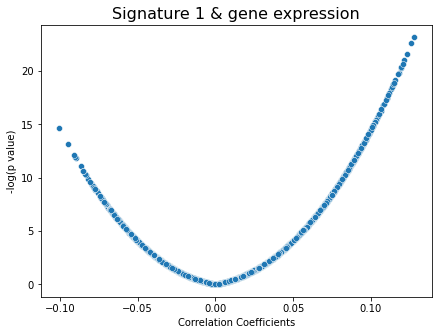

In [63]:
plt.figure(figsize=(7,5))
ax1 = sns.scatterplot(x = correlation_df.iloc[0], y = pval_log.iloc[0])
plt.ylabel('-log(p value)')
plt.xlabel('Correlation Coefficients')
plt.title('Signature 1 & gene expression', size=16)

In [64]:
cin_70 = list(cin_loc['Gene'])

In [65]:
correlation_df_70 = correlation_df[correlation_df.columns.intersection(cin_70)]
pval_df_70 = pval_df[pval_df.columns.intersection(cin_70)]

psig = 0.001/18367

for i in range(0, 5):
    for j in range(0, len(pval_df_70.columns)):
        if pval_df_70.iloc[i][j] > psig:
            correlation_df_70.iloc[i][j] = 0

correlation_df_70

,NDUFAB1,NCAPD2,MCM10,ELAVL1,TRIP13,MCM2,UNG,AURKA,TPX2,KIF4A,...,RRM1,PBK,FEN1,RRM2,DHCR7,ZWILCH,UBE2C,CKAP5,AURKB,PRC1
Signature,,,,,,,,,,,,,,,,,,,,,
Signature_1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Signature_2,0.126151,0.237174,0.315701,0.165231,0.343164,0.274379,0.166364,0.347946,0.344631,0.325488,...,0.133724,0.297096,0.260954,0.283430,0.119827,0.243081,0.357116,0.156108,0.318468,0.315810
Signature_3,-0.132932,-0.205746,-0.292917,-0.121597,-0.323693,-0.253390,-0.145835,-0.349374,-0.346147,-0.340472,...,-0.166504,-0.318923,-0.288919,-0.286148,-0.144377,-0.233087,-0.351603,-0.179046,-0.316102,-0.331575
Signature_4,0.000000,-0.086338,-0.129510,-0.077984,-0.134972,-0.104880,0.000000,-0.128665,-0.128434,-0.121944,...,0.000000,-0.093729,0.000000,-0.113177,0.000000,-0.089744,-0.135876,0.000000,-0.115025,-0.099332
Signature_5,0.000000,-0.071157,-0.093266,0.000000,-0.097381,-0.073161,0.000000,0.000000,-0.087969,-0.088224,...,0.000000,0.000000,0.000000,-0.087787,0.000000,-0.077981,-0.091243,0.000000,-0.094567,0.000000


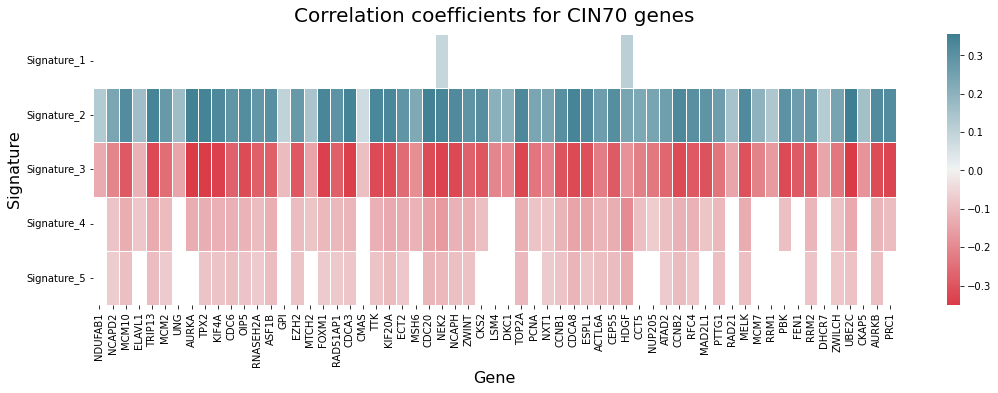

In [66]:
palette = sns.diverging_palette(10, 220, as_cmap=True)

plt.figure(figsize=(18, 5))
ax = sns.heatmap(correlation_df_70[correlation_df_70!=0], cmap=palette, linewidths=0.5)
ax.tick_params(axis="both", which="major", labelsize=10)
plt.xlabel('Gene', fontsize=16)
plt.ylabel('Signature', fontsize=16)
plt.title("Correlation coefficients for CIN70 genes", fontsize=20, y=1.02)
plt.savefig('../figures/cin70_heatmap.pdf')
plt.show()

In [67]:
cin70_expT = exp_final[exp_final.columns.intersection(cin_70)]

In [68]:
cin70_expT['mean'] = cin70_expT.mean(axis=1)

/scratch/64400898/ipykernel_35011/1163041766.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cin70_expT['mean'] = cin70_expT.mean(axis=1)


In [69]:
cin70_expT

,NDUFAB1,NCAPD2,MCM10,ELAVL1,TRIP13,MCM2,UNG,AURKA,TPX2,KIF4A,...,PBK,FEN1,RRM2,DHCR7,ZWILCH,UBE2C,CKAP5,AURKB,PRC1,mean
Sample,,,,,,,,,,,,,,,,,,,,,
TCGA-J8-A3YD,6.6297,3.5559,-1.5105,5.2836,-0.9971,3.3800,5.0162,0.2762,0.1388,-2.1140,...,-0.8599,2.9984,-0.1665,4.3039,1.6920,1.0503,4.2899,-0.2328,2.2175,2.429002
TCGA-J8-A3O1,6.4366,4.1285,-0.9406,5.7019,0.5069,3.7603,4.6972,2.0360,2.4649,0.6050,...,1.5709,2.9319,1.8879,4.8053,2.2872,3.5022,4.9617,1.5709,3.1971,3.299893
TCGA-J8-A3O0,6.7230,4.0662,-2.3884,5.5943,-1.3183,3.6737,4.9279,-0.0877,-0.0130,-1.6394,...,-1.3183,2.7742,0.5170,4.0144,2.2113,0.4125,4.1425,-1.0262,1.9149,2.329880
TCGA-J8-A3NZ,6.6929,3.8147,-0.7834,5.5220,-0.1993,4.2297,4.5466,0.1388,0.4233,-0.8863,...,-0.3566,3.5249,0.9789,3.8075,1.8444,1.6187,4.3632,0.9191,1.9968,2.701172
TCGA-J7-8537,6.8626,3.7730,0.9038,5.1696,2.3564,4.4588,4.9896,3.9561,3.9829,1.9226,...,1.6830,3.6266,5.1664,3.5022,2.5388,4.7159,5.2142,3.9002,4.1219,4.128533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-XF-AAN8,6.2817,1.9452,-1.5951,4.8861,0.1124,1.1117,3.3421,0.0440,0.5666,-1.0559,...,-1.1488,2.5437,1.1382,2.9319,0.9419,2.2452,3.1360,1.1050,2.1013,1.968330
TCGA-YA-A8S7,6.2388,3.9874,1.3283,5.2335,2.2482,3.9166,5.3671,3.8571,4.7751,3.5510,...,3.2632,4.4496,4.4784,4.7165,2.1147,6.2468,4.4602,4.1335,5.0635,4.525382
TCGA-ZF-AA4W,7.5307,3.5136,1.3167,5.2285,3.8441,5.2281,5.5295,4.0383,5.3136,2.6984,...,3.0568,4.9649,5.3438,5.3281,2.3193,7.3603,4.7394,5.0023,6.0464,5.030656


In [45]:
cin70_corr = []
cin70_pval = []

for signature in range(1, 6):
    cin70_corr.append(st.pearsonr(exp[f'Sig{signature}'], cin70_expT['mean'])[0])
    cin70_pval.append(st.pearsonr(exp[f'Sig{signature}'], cin70_expT['mean'])[1])

cin70_pval

[1.1365823886190108e-149,
 2.955720667990217e-142,
 1.8125956455374687e-36,
 1.9095277660986582e-07,
 5.17150203471022e-19]